In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class RPQ:
    def __init__(self, input_dim, projection_dim, quant_bits):
        """
        Initialize the RPQ module.
        :param input_dim: Dimensionality of the input vectors (flattened).
        :param projection_dim: Dimensionality after random projection.
        :param quant_bits: Number of bits for quantization.
        """
        self.input_dim = input_dim
        self.projection_dim = projection_dim
        self.quant_bits = quant_bits
        
        # Random projection matrix (Gaussian random matrix)
        self.projection_matrix = torch.randn(projection_dim, input_dim)
        
    def random_projection(self, x):
        """
        Perform random projection on the input vector.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Projected tensor of shape (batch_size, projection_dim).
        """
        return torch.matmul(x, self.projection_matrix.T)
    
    def quantize(self, x):
        """
        Quantize the projected vector into a bit sequence.
        :param x: Projected tensor of shape (batch_size, projection_dim).
        :return: Quantized bit sequence of shape (batch_size, projection_dim).
        """
        # Normalize the projected values to the range [0, 1]
        x_min = x.min(dim=1, keepdim=True)[0]
        x_max = x.max(dim=1, keepdim=True)[0]
        x_normalized = (x - x_min) / (x_max - x_min + 1e-8)
        
        # Quantize to a discrete set of values based on the number of bits
        quantized_x = torch.floor(x_normalized * (2 ** self.quant_bits)).int()
        
        return quantized_x
    
    def compute_signature(self, x):
        """
        Compute the RPQ signature for the input vector.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Signature tensor of shape (batch_size, projection_dim).
        """
        projected_x = self.random_projection(x)
        signature = self.quantize(projected_x)
        
        return signature

# Cache mechanism to store and compare signatures
class InputSimilarityCache:
    def __init__(self):
        # Dictionary to store signatures and their corresponding results
        self.cache = {}
    
    def check_similarity(self, signature):
        """
        Check if a given signature is already in the cache.
        :param signature: The signature to check.
        :return: Boolean indicating whether a similar signature exists in cache.
                 If found, return True and the cached result; otherwise return False.
        """
        sig_tuple = tuple(signature.view(-1).tolist())  # Convert tensor to tuple for hashing
        
        if sig_tuple in self.cache:
            return True, self.cache[sig_tuple]
        
        return False, None
    
    def store_signature(self, signature, result):
        """
        Store a new signature and its corresponding result in cache.
        :param signature: The signature to store.
        :param result: The result associated with this signature.
        """
        sig_tuple = tuple(signature.view(-1).tolist())  # Convert tensor to tuple for hashing
        self.cache[sig_tuple] = result

# Define ResNet50 model from scratch for training purposes
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        # Use torchvision's ResNet50 architecture but without pretrained weights
        self.model = models.resnet50(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

# Function to run ResNet50 training with or without RPQ/MCACHE
def train_resnet50_with_rpq(inputs, labels, rpq=None, cache=None):
    # Define ResNet50 model
    resnet50 = ResNet50().train()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet50.parameters(), lr=0.001)
    
    total_computations = 0  # Track total computations
    
    for i in range(inputs.size(0)):
        
        if rpq is not None and cache is not None:
            # Flatten each image before computing RPQ signature
            flattened_input = inputs[i].view(1, -1)  # Flatten image from [3x224x224] to [1x150528]
            
            # Compute RPQ signature for each flattened input vector
            signature = rpq.compute_signature(flattened_input)
            
            # Check if a similar input has been processed before
            is_similar, cached_result = cache.check_similarity(signature)
            
            if is_similar:
                print(f"Input {i}: Similarity found! Skipping redundant computation.")
                continue  # Skip forward/backward pass
            
            else:
                print(f"Input {i}: No similarity found. Performing computation.")
                total_computations += 1
                
                # Forward pass through ResNet50
                outputs = resnet50(inputs[i].unsqueeze(0))
                
                # Compute loss and perform backward pass
                loss = criterion(outputs, labels[i].unsqueeze(0))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Store result in cache along with its signature
                cache.store_signature(signature, outputs)
        
        else:
            print(f"Input {i}: Performing baseline computation.")
            total_computations += 1
            
            # Forward pass through ResNet50 without caching
            outputs = resnet50(inputs[i].unsqueeze(0))
            
            # Compute loss and perform backward pass
            loss = criterion(outputs, labels[i].unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return total_computations

# Example usage with controlled perturbations
if __name__ == "__main__":
    # Define dimensions for flattening images (3x224x224 -> 150528)
    input_dim = 224 * 224 * 3  # Input dimension for ResNet50 images (3x224x224)
    projection_dim = 100  # Projected dimension for RPQ
    quant_bits = 4  # Number of bits for quantization
    
    # Create an instance of RPQ and cache
    rpq = RPQ(input_dim=input_dim, projection_dim=projection_dim, quant_bits=quant_bits)
    cache = InputSimilarityCache()
    
    # Generate a base image and create slightly perturbed versions of it
    batch_size = 10
    num_classes = 1000  # Number of classes in ImageNet dataset
    
    base_input = torch.randn(3, 224, 224)  # Base image
    
    # Create perturbed versions by adding small noise to the base image
    inputs = base_input + 0.01 * torch.randn(batch_size, 3, 224, 224)  
    labels = torch.randint(0, num_classes, (batch_size,), dtype=torch.long)  # Random labels
    
    print("Training baseline system without WS:")
    baseline_computations = train_resnet50_with_rpq(inputs.clone(), labels)  # Baseline system without WS
    
    print("\nTraining system with WS dataflow using RPQ and MCACHE:")
    ws_computations = train_resnet50_with_rpq(inputs.clone(), labels, rpq=rpq, cache=cache)  # System with WS dataflow
    
    print(f"\nTotal computations in baseline system: {baseline_computations}")
    print(f"Total computations in WS system with RPQ/MCACHE: {ws_computations}")

Training baseline system without WS:
Input 0: Performing baseline computation.
Input 1: Performing baseline computation.
Input 2: Performing baseline computation.
Input 3: Performing baseline computation.
Input 4: Performing baseline computation.
Input 5: Performing baseline computation.
Input 6: Performing baseline computation.
Input 7: Performing baseline computation.
Input 8: Performing baseline computation.
Input 9: Performing baseline computation.

Training system with WS dataflow using RPQ and MCACHE:
Input 0: No similarity found. Performing computation.
Input 1: No similarity found. Performing computation.
Input 2: No similarity found. Performing computation.
Input 3: No similarity found. Performing computation.
Input 4: Similarity found! Skipping redundant computation.
Input 5: Similarity found! Skipping redundant computation.
Input 6: Similarity found! Skipping redundant computation.
Input 7: No similarity found. Performing computation.
Input 8: No similarity found. Performing

Training baseline system without WS:
Input Vector 0: 
[ 1.77830805  0.39673966  0.96275103 ...  1.5456486   1.77904098
 -0.41382903]
Input 0: Performing baseline computation.
Input Vector 1: 
[ 1.7531359   0.38576447  0.97940135 ...  1.569255    1.76757386
 -0.4286924 ]
Input 1: Performing baseline computation.
Input Vector 2: 
[ 1.7631238   0.39680271  0.9848966  ...  1.544547    1.78288554
 -0.42692535]
Input 2: Performing baseline computation.
Input Vector 3: 
[ 1.76162675  0.39850917  0.98969458 ...  1.5375335   1.77245231
 -0.40943078]
Input 3: Performing baseline computation.
Input Vector 4: 
[ 1.76060868  0.39994359  0.97024779 ...  1.57119221  1.7717411
 -0.41727425]
Input 4: Performing baseline computation.
Input Vector 5: 
[ 1.7737314   0.39427718  0.97677938 ...  1.54062138  1.77557746
 -0.41983422]
Input 5: Performing baseline computation.
Input Vector 6: 
[ 1.76100928  0.4059369   0.9712469  ...  1.55671905  1.75731445
 -0.4119689 ]
Input 6: Performing baseline computation

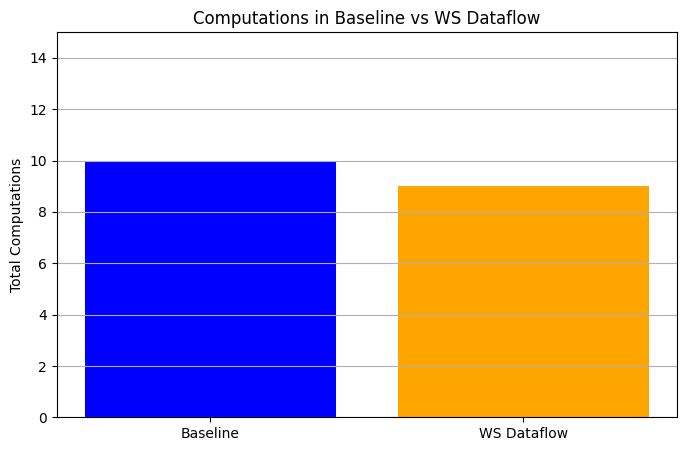

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

class RPQ:
    def __init__(self, input_dim, projection_dim, quant_bits):
        """
        Initialize the RPQ module.
        :param input_dim: Dimensionality of the input vectors (flattened).
        :param projection_dim: Dimensionality after random projection.
        :param quant_bits: Number of bits for quantization.
        """
        self.input_dim = input_dim
        self.projection_dim = projection_dim
        self.quant_bits = quant_bits
        
        # Random projection matrix (Gaussian random matrix)
        self.projection_matrix = np.random.randn(projection_dim, input_dim)
        
    def random_projection(self, x):
        """
        Perform random projection on the input vector.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Projected tensor of shape (batch_size, projection_dim).
        """
        return np.dot(x, self.projection_matrix.T)
    
    def quantize(self, x):
        """
        Quantize the projected vector into a bit sequence.
        :param x: Projected tensor of shape (batch_size, projection_dim).
        :return: Quantized bit sequence of shape (batch_size, projection_dim).
        """
        x_min = np.min(x, axis=1, keepdims=True)
        x_max = np.max(x, axis=1, keepdims=True)
        x_normalized = (x - x_min) / (x_max - x_min + 1e-8)
        
        # Quantize to a discrete set of values based on the number of bits
        quantized_x = np.floor(x_normalized * (2 ** self.quant_bits)).astype(int)
        
        return quantized_x
    
    def compute_signature(self, x):
        """
        Compute the RPQ signature for the input vector.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Signature tensor of shape (batch_size, projection_dim).
        """
        projected_x = self.random_projection(x)
        signature = self.quantize(projected_x)
        
        return signature

# Cache mechanism to store and compare signatures
class InputSimilarityCache:
    def __init__(self):
        # Dictionary to store signatures and their corresponding results
        self.cache = {}
    
    def check_similarity(self, signature):
        """
        Check if a given signature is already in the cache.
        :param signature: The signature to check.
        :return: Boolean indicating whether a similar signature exists in cache.
                 If found, return True and the cached result; otherwise return False.
        """
        sig_tuple = tuple(signature.flatten())  # Convert tensor to tuple for hashing
        
        if sig_tuple in self.cache:
            return True, self.cache[sig_tuple]
        
        return False, None
    
    def store_signature(self, signature, result):
        """
        Store a new signature and its corresponding result in cache.
        :param signature: The signature to store.
        :param result: The result associated with this signature.
        """
        sig_tuple = tuple(signature.flatten())  # Convert tensor to tuple for hashing
        self.cache[sig_tuple] = result

# Function to run ResNet50 training with or without RPQ/MCACHE
def train_resnet50_with_rpq(inputs, labels, rpq=None, cache=None):
    total_computations = 0  # Track total computations
    
    for i in range(len(inputs)):
        
        print(f"Input Vector {i}: \n{inputs[i].flatten()}")  # Print flattened input vector
        
        if rpq is not None and cache is not None:
            # Flatten each image before computing RPQ signature
            flattened_input = inputs[i].flatten()  # Flatten image from [3x224x224] to [150528]
            
            # Compute RPQ signature for each flattened input vector
            signature = rpq.compute_signature(flattened_input[np.newaxis, :])
            
            # Check if a similar input has been processed before
            is_similar, cached_result = cache.check_similarity(signature)
            
            if is_similar:
                print(f"Input {i}: Similarity found! Skipping redundant computation.")
                continue  # Skip forward/backward pass
            
            else:
                print(f"Input {i}: No similarity found. Performing computation.")
                total_computations += 1
                
                # Simulate output computation and loss calculation
                generated_output = np.random.randn(1, 1000)  # Assuming 1000 classes
                loss = np.random.rand()  # Simulating loss computation
                
                # Store result in cache along with its signature
                cache.store_signature(signature, generated_output)
        
        else:
            print(f"Input {i}: Performing baseline computation.")
            total_computations += 1
            
            # Simulate output computation and loss calculation
            generated_output = np.random.randn(1, 1000)  # Assuming 1000 classes
            loss = np.random.rand()  # Simulating loss computation
    
    return total_computations

# Visualization function for computations comparison
def visualize_computations(baseline_count, ws_count):
    labels = ['Baseline', 'WS Dataflow']
    counts = [baseline_count, ws_count]
    
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title('Computations in Baseline vs WS Dataflow')
    plt.ylabel('Total Computations')
    plt.ylim(0, max(counts) + 5)
    plt.grid(axis='y')
    plt.show()

# Example usage with controlled perturbations and visualization
if __name__ == "__main__":
    np.random.seed(0)  # For reproducibility
    
    batch_size = 10
    num_classes = 1000
    
    # Generate a base image and create slightly perturbed versions of it
    base_input = np.random.randn(3, 224, 224)  
    inputs = base_input + 0.01 * np.random.randn(batch_size, 3, 224, 224)  
    labels = np.random.randint(0, num_classes, batch_size)  
    
    print("Training baseline system without WS:")
    baseline_computations = train_resnet50_with_rpq(inputs.copy(), labels)  
    
    print("\nTraining system with WS dataflow using RPQ and MCACHE:")
    rpq = RPQ(input_dim=3*224*224, projection_dim=100, quant_bits=4)
    cache = InputSimilarityCache()
    
    ws_computations = train_resnet50_with_rpq(inputs.copy(), labels.copy(), rpq=rpq, cache=cache)  
    
    print(f"\nTotal computations in baseline system: {baseline_computations}")
    print(f"Total computations in WS system with RPQ/MCACHE: {ws_computations}")
    
    visualize_computations(baseline_computations, ws_computations)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class RPQ:
    def __init__(self, input_dim, projection_dim, quant_bits):
        """
        Initialize the RPQ module.
        :param input_dim: Dimensionality of the input vectors (flattened).
        :param projection_dim: Dimensionality after random projection.
        :param quant_bits: Number of bits for quantization.
        """
        self.input_dim = input_dim
        self.projection_dim = projection_dim
        self.quant_bits = quant_bits
        
        # Random projection matrix (Gaussian random matrix)
        self.projection_matrix = torch.randn(projection_dim, input_dim)
        
    def random_projection(self, x):
        """
        Perform random projection on the input vector.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Projected tensor of shape (batch_size, projection_dim).
        """
        return torch.matmul(x, self.projection_matrix.T)
    
    def quantize(self, x):
        """
        Quantize the projected vector into a bit sequence.
        :param x: Projected tensor of shape (batch_size, projection_dim).
        :return: Quantized bit sequence of shape (batch_size, projection_dim).
        """
        # Normalize the projected values to the range [0, 1]
        x_min = x.min(dim=1, keepdim=True)[0]
        x_max = x.max(dim=1, keepdim=True)[0]
        x_normalized = (x - x_min) / (x_max - x_min + 1e-8)
        
        # Quantize to a discrete set of values based on the number of bits
        quantized_x = torch.floor(x_normalized * (2 ** self.quant_bits)).int()
        
        return quantized_x
    
    def compute_signature(self, x):
        """
        Compute the RPQ signature for the input vector.
        :param x: Input tensor of shape (batch_size, input_dim).
        :return: Signature tensor of shape (batch_size, projection_dim).
        """
        projected_x = self.random_projection(x)
        signature = self.quantize(projected_x)
        
        return signature

# Cache mechanism to store and compare signatures
class InputSimilarityCache:
    def __init__(self):
        # Dictionary to store signatures and their corresponding results
        self.cache = {}
    
    def check_similarity(self, signature):
        """
        Check if a given signature is already in the cache.
        :param signature: The signature to check.
        :return: Boolean indicating whether a similar signature exists in cache.
                 If found, return True and the cached result; otherwise return False.
        """
        sig_tuple = tuple(signature.view(-1).tolist())  # Convert tensor to tuple for hashing
        
        if sig_tuple in self.cache:
            return True, self.cache[sig_tuple]
        
        # Check for similar signatures with tolerance
        for cached_signature, result in self.cache.items():
            similarity = torch.sum(torch.abs(signature - torch.tensor(cached_signature)))
            if similarity.item() < 0.1:  # Set a threshold for similarity
                return True, result
        
        return False, None
    
    def store_signature(self, signature, result):
        """
        Store a new signature and its corresponding result in cache.
        :param signature: The signature to store.
        :param result: The result associated with this signature.
        """
        sig_tuple = tuple(signature.view(-1).tolist())  # Convert tensor to tuple for hashing
        self.cache[sig_tuple] = result

# Define ResNet50 model from scratch for training purposes
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        # Use torchvision's ResNet50 architecture but without pretrained weights
        self.model = models.resnet50(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

# Function to run ResNet50 training with or without RPQ/MCACHE
def train_resnet50_with_rpq(inputs, labels, rpq=None, cache=None):
    # Define ResNet50 model
    resnet50 = ResNet50().train()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet50.parameters(), lr=0.001)
    
    total_computations = 0  # Track total computations
    
    for i in range(inputs.size(0)):
        
        if rpq is not None and cache is not None:
            # Flatten each image before computing RPQ signature
            flattened_input = inputs[i].view(1, -1)  # Flatten image from [3x224x224] to [1x150528]
            
            # Compute RPQ signature for each flattened input vector
            signature = rpq.compute_signature(flattened_input)
            
            # Check if a similar input has been processed before
            is_similar, cached_result = cache.check_similarity(signature)
            
            if is_similar:
                print(f"Input {i}: Similarity found! Skipping redundant computation.")
                continue  # Skip forward/backward pass
            
            else:
                print(f"Input {i}: No similarity found. Performing computation.")
                total_computations += 1
                
                # Forward pass through ResNet50
                outputs = resnet50(inputs[i].unsqueeze(0))
                
                # Compute loss and perform backward pass
                loss = criterion(outputs, labels[i].unsqueeze(0))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Store result in cache along with its signature
                cache.store_signature(signature, outputs)
        
        else:
            print(f"Input {i}: Performing baseline computation.")
            total_computations += 1
            
            # Forward pass through ResNet50 without caching
            outputs = resnet50(inputs[i].unsqueeze(0))
            
            # Compute loss and perform backward pass
            loss = criterion(outputs, labels[i].unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return total_computations

# Example usage with controlled perturbations
if __name__ == "__main__":
    # Define dimensions for flattening images (3x224x224 -> 150528)
    input_dim = 224 * 224 * 3  # Input dimension for ResNet50 images (3x224x224)
    projection_dim = 100  # Projected dimension for RPQ
    quant_bits = 4  # Number of bits for quantization
    
    # Create an instance of RPQ and cache
    rpq = RPQ(input_dim=input_dim, projection_dim=projection_dim, quant_bits=quant_bits)
    cache = InputSimilarityCache()
    
    # Generate a base image and create slightly perturbed versions of it
    batch_size = 10
    num_classes = 1000  # Number of classes in ImageNet dataset
    
    base_input = torch.randn(3, 224, 224)  # Base image
    
    # Create perturbed versions by adding small noise to the base image
    inputs = base_input + 0.01 * torch.randn(batch_size, 3, 224, 224)  
    labels = torch.randint(0, num_classes, (batch_size,), dtype=torch.long)  # Random labels
    
    print("Training baseline system without WS:")
    baseline_computations = train_resnet50_with_rpq(inputs.clone(), labels)  # Baseline system without WS
    
    print("\nTraining system with WS dataflow using RPQ and MCACHE:")
    ws_computations = train_resnet50_with_rpq(inputs.clone(), labels, rpq=rpq, cache=cache)  # System with WS dataflow
    
    print(f"\nTotal computations in baseline system: {baseline_computations}")
    print(f"Total computations in WS system with RPQ/MCACHE: {ws_computations}")


Training baseline system without WS:
Input 0: Performing baseline computation.
Input 1: Performing baseline computation.
Input 2: Performing baseline computation.
Input 3: Performing baseline computation.
Input 4: Performing baseline computation.
Input 5: Performing baseline computation.
Input 6: Performing baseline computation.
Input 7: Performing baseline computation.
Input 8: Performing baseline computation.
Input 9: Performing baseline computation.

Training system with WS dataflow using RPQ and MCACHE:
Input 0: No similarity found. Performing computation.
Input 1: No similarity found. Performing computation.
Input 2: No similarity found. Performing computation.
Input 3: No similarity found. Performing computation.
Input 4: No similarity found. Performing computation.
Input 5: No similarity found. Performing computation.
Input 6: Similarity found! Skipping redundant computation.
Input 7: No similarity found. Performing computation.
Input 8: No similarity found. Performing computati

In [1]:
import os
import urllib.request
import tarfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.backends.cudnn as cudnn

# Function to download and extract CIFAR-10 dataset
def download_and_extract_cifar10(download_dir='data', url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'):
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    # Download the dataset if it's not already present
    dataset_path = os.path.join(download_dir, 'cifar-10-python.tar.gz')
    
    if not os.path.exists(dataset_path):
        print(f"Downloading CIFAR-10 dataset from {url}...")
        urllib.request.urlretrieve(url, dataset_path)
    
    # Extract if not already extracted
    extracted_dir = os.path.join(download_dir, 'cifar-10-batches-py')
    
    if not os.path.exists(extracted_dir):
        print(f"Extracting CIFAR-10 dataset...")
        with tarfile.open(dataset_path, 'r:gz') as tar_ref:
            tar_ref.extractall(download_dir)

# RPQ module for random projection and quantization
class RPQ:
    def __init__(self, input_dim, projection_dim, quant_bits, device):
        self.device = device
        self.input_dim = input_dim
        self.projection_dim = projection_dim
        self.quant_bits = quant_bits
        self.projection_matrix = torch.randn(projection_dim, input_dim, device=device)
        
    def random_projection(self, x):
        return torch.matmul(x, self.projection_matrix.T)
    
    def quantize(self, x):
        x_min = x.min(dim=1, keepdim=True)[0]
        x_max = x.max(dim=1, keepdim=True)[0]
        x_normalized = (x - x_min) / (x_max - x_min + 1e-8)
        quantized_x = torch.floor(x_normalized * (2 ** self.quant_bits)).int()
        return quantized_x
    
    def compute_signature(self, x):
        projected_x = self.random_projection(x)
        signature = self.quantize(projected_x)
        return signature

# Model and training function
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

# A simple input similarity cache
class InputSimilarityCache:
    def __init__(self):
        self.cache = {}

    def check_similarity(self, signature):
        signature_tuple = tuple(signature.view(-1).tolist())
        return signature_tuple in self.cache, self.cache.get(signature_tuple)

    def store_signature(self, signature, result):
        signature_tuple = tuple(signature.view(-1).tolist())
        self.cache[signature_tuple] = result

def train_resnet50_with_rpq(trainloader, validloader, rpq=None, cache=None, num_epochs=5, device='cpu'):
    resnet50 = ResNet50().to(device)  # Ensure the model is on the correct device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet50.parameters(), lr=0.001)
    
    total_computations = 0  # Track total computations
    
    # Training Loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs and labels are on the same device
            
            if rpq is not None and cache is not None:
                flattened_input = inputs.view(inputs.size(0), -1).to(device)  # Move to the same device as the model
                signature = rpq.compute_signature(flattened_input)
                is_similar, cached_result = cache.check_similarity(signature)
                
                if is_similar:
                    continue  # Skip if similar signature is found
                else:
                    total_computations += 1
                    outputs = resnet50(inputs)
                    loss = criterion(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    cache.store_signature(signature, outputs)
            else:
                total_computations += 1  # Increment for each forward pass
                outputs = resnet50(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_acc = 100 * correct_train / total_train
        print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_acc:.2f}%')
        
        # Validation Loop
        correct_val = 0
        total_val = 0
        resnet50.eval()
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs and labels are on the same device
                outputs = resnet50(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_acc = 100 * correct_val / total_val
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.2f}%')
        
    return total_computations

if __name__ == "__main__":
    # Download CIFAR-10
    download_and_extract_cifar10()

    # Set up data transforms and loaders
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # Load CIFAR-10 dataset
    trainset = datasets.CIFAR10(root='data', train=True, download=False, transform=transform)
    testset = datasets.CIFAR10(root='data', train=False, download=False, transform=transform)

    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    validloader = DataLoader(testset, batch_size=32, shuffle=False)

    # RPQ and cache setup
    input_dim = 32 * 32 * 3  # CIFAR-10 image size (32x32x3)
    projection_dim = 100  # Projected dimension for RPQ
    quant_bits = 4  # Number of bits for quantization
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    rpq = RPQ(input_dim=input_dim, projection_dim=projection_dim, quant_bits=quant_bits, device=device)
    cache = InputSimilarityCache()

    print(f"Training on {device}")
    
    # Train with RPQ and cache
    print("Training with RPQ and cache...")
    computations_with_rpq = train_resnet50_with_rpq(trainloader, validloader, rpq=rpq, cache=cache, num_epochs=3, device=device)
    print(f"Total computations with RPQ: {computations_with_rpq}")
    
    # Train without RPQ
    print("Training without RPQ...")
    computations_without_rpq = train_resnet50_with_rpq(trainloader, validloader, rpq=None, cache=None, num_epochs=3, device=device)
    print(f"Total computations without RPQ: {computations_without_rpq}")


c:\users\vishw\appdata\local\programs\python\python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on cuda
Training with RPQ and cache...


c:\users\vishw\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\users\vishw\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/3, Training Accuracy: 16.28%
Epoch 1/3, Validation Accuracy: 22.96%
Epoch 2/3, Training Accuracy: 26.90%
Epoch 2/3, Validation Accuracy: 32.00%
Epoch 3/3, Training Accuracy: 35.01%
Epoch 3/3, Validation Accuracy: 36.99%
Total computations with RPQ: 4689
Training without RPQ...
Epoch 1/3, Training Accuracy: 17.32%
Epoch 1/3, Validation Accuracy: 21.48%
Epoch 2/3, Training Accuracy: 26.19%
Epoch 2/3, Validation Accuracy: 32.27%
Epoch 3/3, Training Accuracy: 36.15%
Epoch 3/3, Validation Accuracy: 36.89%
Total computations without RPQ: 4689
